Библиотеки, используемые в работе

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as functional
from torchvision import transforms

Загрузка необзодимого (исходного) набора данных и соответствующих меток классов

In [2]:
csv_path = "C:/Users/zhura/Desktop/paths.csv"
df = pd.read_csv(csv_path, delimiter=";", names=["Absolute path", "Relative path", "Label"])
images = df["Absolute path"].to_list()
random.shuffle(images)
img_label=[]
for i in range(len(images)):
    img_label.append(os.path.basename(os.path.dirname(images[i])))
print(img_label[:10])

['brown bear', 'polar bear', 'brown bear', 'polar bear', 'brown bear', 'brown bear', 'polar bear', 'brown bear', 'brown bear', 'brown bear']


Разделение в заданном соотношении 80:10:10 и проверка на сбаллансированность

In [3]:
train_list = images[0:int(len(images) * 0.8)]
test_list = images[int(len(images) * 0.8) : int(len(images) * 0.9)]
valid_list = images[int(len(images) * 0.9) : int(len(images))]

print(len(train_list), len(test_list), len(valid_list))

1600 200 200


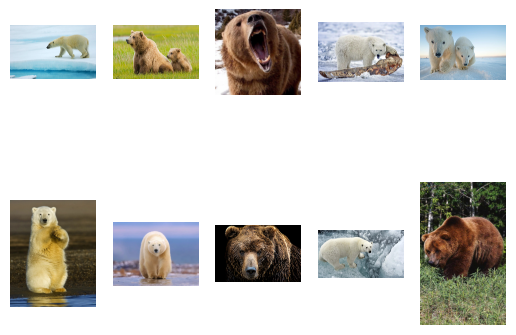

In [4]:
random_idx = np.random.randint(1,len(images),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(images[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
plt.show()

Формирование модели сверточной нейронной сети для решения задач классификации

In [5]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.dataset)
        return self.filelength
    
    def __getitem__(self,index:int):
        img_label=[]
        for i in range(len(self.dataset)):
            img_label.append(os.path.basename(os.path.dirname(self.dataset[i])))
        img_path = self.dataset[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[index]
        if label == 'polar bear':
            label=0
        elif label == 'brown bear':
            label=1
        return img_transformed,label

In [6]:
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(train_list, transform=fixed_transforms)
test_data = dataset(test_list, transform=fixed_transforms)
val_data = dataset(valid_list, transform=fixed_transforms)
print(train_data.transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


Построение модели

In [7]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Отрисовка графиков

In [9]:
def draw_results(epochs, train_acc, train_loss, val_acc, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), train_acc, color="green", label="Training accuracy")
    ax2.plot(range(epochs), train_loss, color="green", label="Training loss")
    ax1.plot(range(epochs), val_acc, color="orange", label="Validation accuracy")
    ax2.plot(range(epochs), val_loss, color="orange", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show() 

Цикл обучения 

In [10]:
def train_loop(epochs, batch_size, lear):
    for param in model.parameters():
        param.data.uniform_(-0.1, 0.1)
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, training accuracy : {}, training loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, validation accuracy : {}, validation loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    draw_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

Epoch : 1, training accuracy : 0.7524999380111694, training loss : 0.662428617477417
Epoch : 1, validation accuracy : 0.8899999856948853, validation loss : 0.6104749441146851
Epoch : 2, training accuracy : 0.8762499690055847, training loss : 0.5436320304870605
Epoch : 2, validation accuracy : 0.8650000095367432, validation loss : 0.46858784556388855
Epoch : 3, training accuracy : 0.90687495470047, training loss : 0.40428420901298523
Epoch : 3, validation accuracy : 0.9299999475479126, validation loss : 0.34286612272262573
Epoch : 4, training accuracy : 0.9449999928474426, training loss : 0.29336923360824585
Epoch : 4, validation accuracy : 0.9449999928474426, validation loss : 0.23902545869350433
Epoch : 5, training accuracy : 0.9575000405311584, training loss : 0.1983242779970169
Epoch : 5, validation accuracy : 0.9749999642372131, validation loss : 0.13958525657653809
Epoch : 6, training accuracy : 0.9581249356269836, training loss : 0.15280264616012573
Epoch : 6, validation accuracy

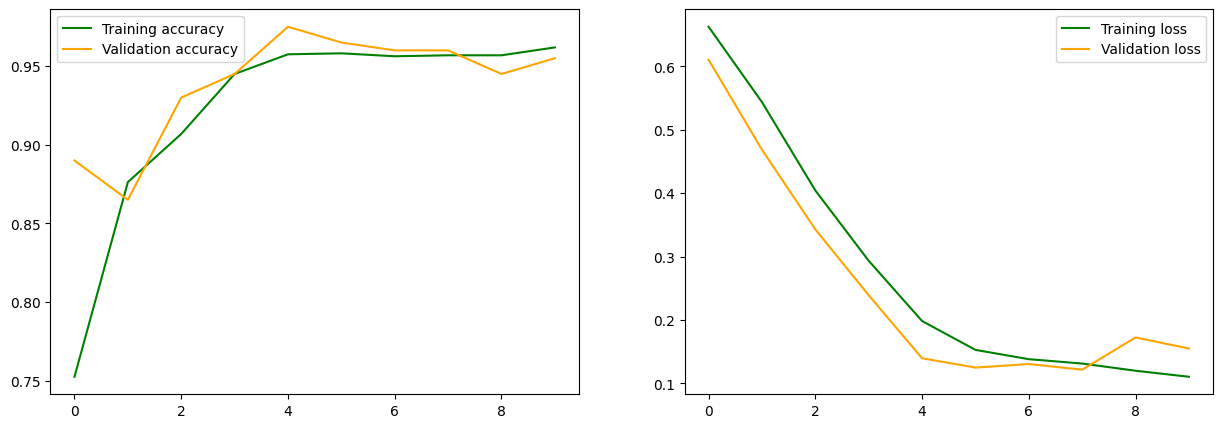

In [11]:
train_loop(10, 100, 0.001)  

Epoch : 1, training accuracy : 0.5993750095367432, training loss : 0.6734006404876709
Epoch : 1, validation accuracy : 0.8349999785423279, validation loss : 0.6485479474067688
Epoch : 2, training accuracy : 0.8662499785423279, training loss : 0.6261372566223145
Epoch : 2, validation accuracy : 0.875, validation loss : 0.5915502309799194
Epoch : 3, training accuracy : 0.8887499570846558, training loss : 0.5569320321083069
Epoch : 3, validation accuracy : 0.8650000095367432, validation loss : 0.512851357460022
Epoch : 4, training accuracy : 0.9137499928474426, training loss : 0.47055286169052124
Epoch : 4, validation accuracy : 0.8999999761581421, validation loss : 0.42140793800354004
Epoch : 5, training accuracy : 0.9268749952316284, training loss : 0.38543081283569336
Epoch : 5, validation accuracy : 0.9350000023841858, validation loss : 0.33422157168388367
Epoch : 6, training accuracy : 0.9418750405311584, training loss : 0.3022575080394745
Epoch : 6, validation accuracy : 0.939999997

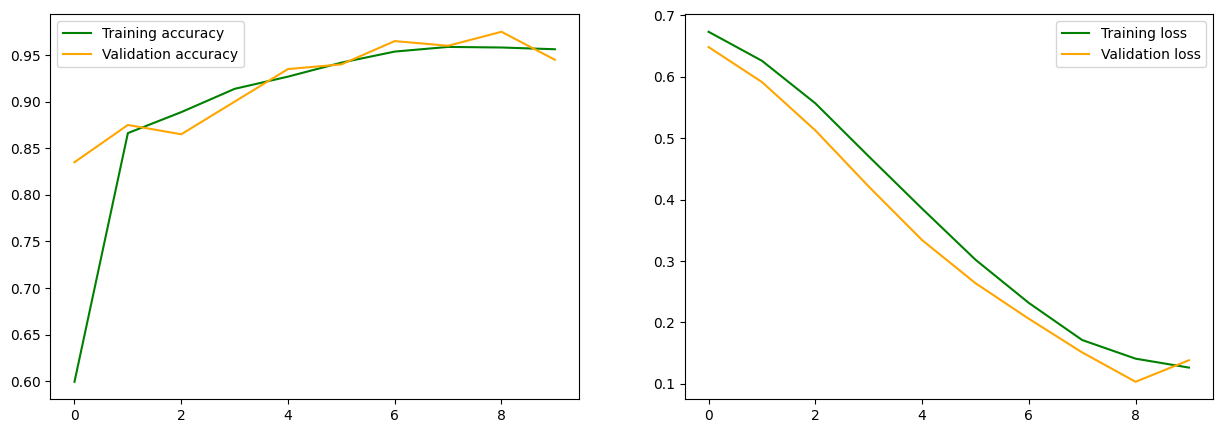

In [12]:
train_loop(10, 200, 0.001)

Epoch : 1, training accuracy : 0.5022222399711609, training loss : 0.6844276189804077
Epoch : 1, validation accuracy : 0.6549999713897705, validation loss : 0.6682049632072449
Epoch : 2, training accuracy : 0.8066667318344116, training loss : 0.6594504714012146
Epoch : 2, validation accuracy : 0.9249999523162842, validation loss : 0.640799343585968
Epoch : 3, training accuracy : 0.9322222471237183, training loss : 0.6261080503463745
Epoch : 3, validation accuracy : 0.8999999761581421, validation loss : 0.6017526388168335
Epoch : 4, training accuracy : 0.9344444274902344, training loss : 0.5769574046134949
Epoch : 4, validation accuracy : 0.8999999761581421, validation loss : 0.5437300205230713
Epoch : 5, training accuracy : 0.9388889074325562, training loss : 0.5097038745880127
Epoch : 5, validation accuracy : 0.9300000071525574, validation loss : 0.4647080898284912
Epoch : 6, training accuracy : 0.9227777719497681, training loss : 0.4394463300704956
Epoch : 6, validation accuracy : 0.

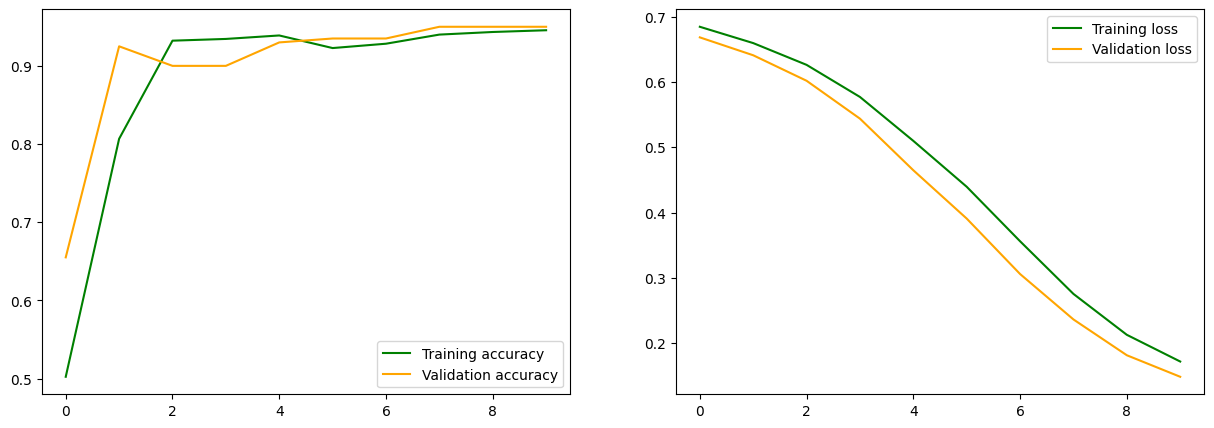

In [13]:
train_loop(10, 300, 0.001)

Epoch : 1, training accuracy : 0.87562495470047, training loss : 0.5139623880386353
Epoch : 1, validation accuracy : 0.9449999928474426, validation loss : 0.22748959064483643
Epoch : 2, training accuracy : 0.9356249570846558, training loss : 0.19260038435459137
Epoch : 2, validation accuracy : 0.9549999833106995, validation loss : 0.1746063232421875
Epoch : 3, training accuracy : 0.9418748617172241, training loss : 0.16352500021457672
Epoch : 3, validation accuracy : 0.9350000023841858, validation loss : 0.17468497157096863
Epoch : 4, training accuracy : 0.9549999237060547, training loss : 0.14504244923591614
Epoch : 4, validation accuracy : 0.949999988079071, validation loss : 0.1708049178123474
Epoch : 5, training accuracy : 0.9499999284744263, training loss : 0.13845139741897583
Epoch : 5, validation accuracy : 0.9549999833106995, validation loss : 0.11000196635723114
Epoch : 6, training accuracy : 0.9518749117851257, training loss : 0.14180421829223633
Epoch : 6, validation accurac

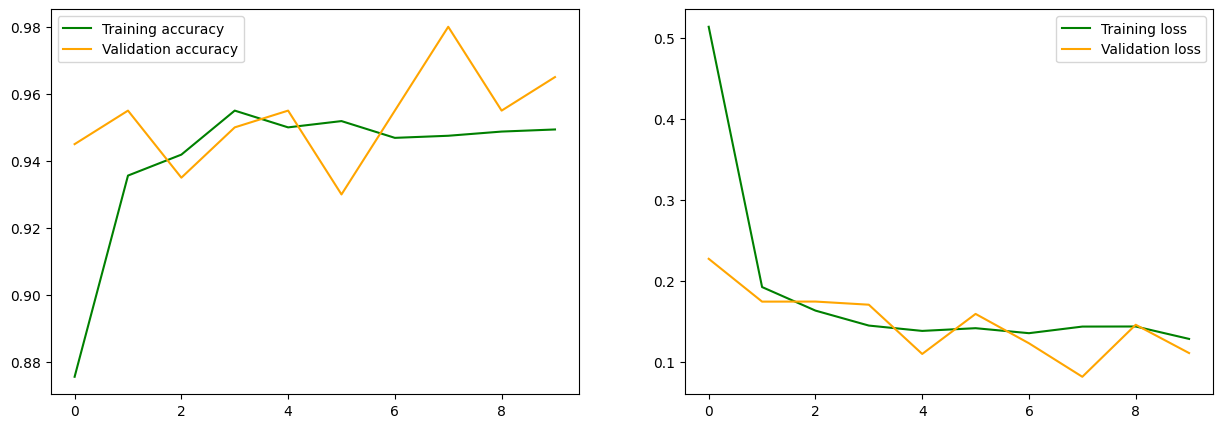

In [14]:
train_loop(10, 100, 0.005)

Epoch : 1, training accuracy : 0.7549999952316284, training loss : 0.6256695985794067
Epoch : 1, validation accuracy : 0.9199999570846558, validation loss : 0.473119854927063
Epoch : 2, training accuracy : 0.9318749308586121, training loss : 0.3077833950519562
Epoch : 2, validation accuracy : 0.9149999618530273, validation loss : 0.22621528804302216
Epoch : 3, training accuracy : 0.9374999403953552, training loss : 0.1784037947654724
Epoch : 3, validation accuracy : 0.9350000023841858, validation loss : 0.25775352120399475
Epoch : 4, training accuracy : 0.9375, training loss : 0.1754617691040039
Epoch : 4, validation accuracy : 0.9399999976158142, validation loss : 0.2017233967781067
Epoch : 5, training accuracy : 0.9462499618530273, training loss : 0.14212536811828613
Epoch : 5, validation accuracy : 0.9649999737739563, validation loss : 0.08847712725400925
Epoch : 6, training accuracy : 0.9481250047683716, training loss : 0.14233896136283875
Epoch : 6, validation accuracy : 0.9599999

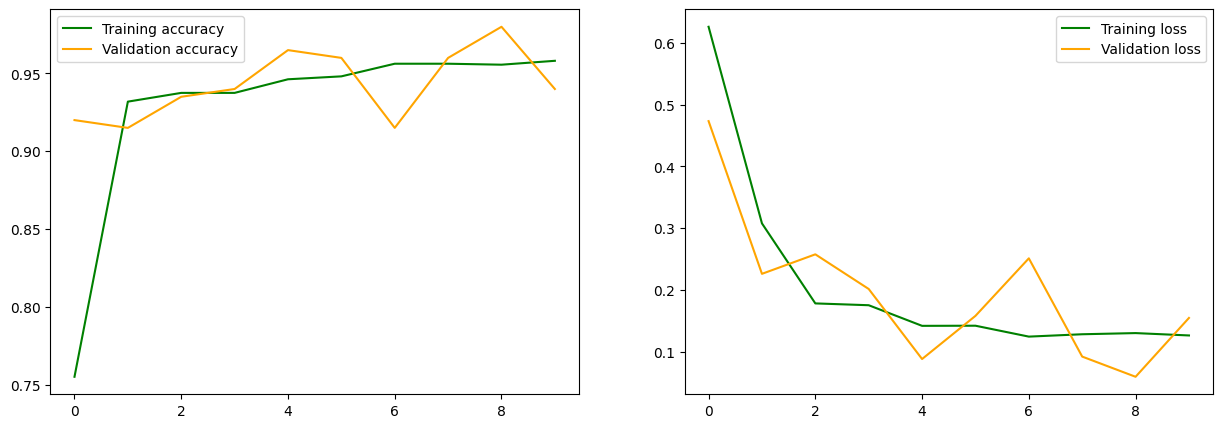

In [15]:
train_loop(10, 200, 0.005)

Epoch : 1, training accuracy : 0.7300000190734863, training loss : 0.6469584703445435
Epoch : 1, validation accuracy : 0.9249999523162842, validation loss : 0.5463770627975464
Epoch : 2, training accuracy : 0.929444432258606, training loss : 0.4322360157966614
Epoch : 2, validation accuracy : 0.9350000023841858, validation loss : 0.25806528329849243
Epoch : 3, training accuracy : 0.9361112117767334, training loss : 0.20501720905303955
Epoch : 3, validation accuracy : 0.9199999570846558, validation loss : 0.17251423001289368
Epoch : 4, training accuracy : 0.9377778768539429, training loss : 0.17113205790519714
Epoch : 4, validation accuracy : 0.9649999737739563, validation loss : 0.13020464777946472
Epoch : 5, training accuracy : 0.9372222423553467, training loss : 0.20339477062225342
Epoch : 5, validation accuracy : 0.9699999690055847, validation loss : 0.10982692986726761
Epoch : 6, training accuracy : 0.9544445276260376, training loss : 0.13373978435993195
Epoch : 6, validation accur

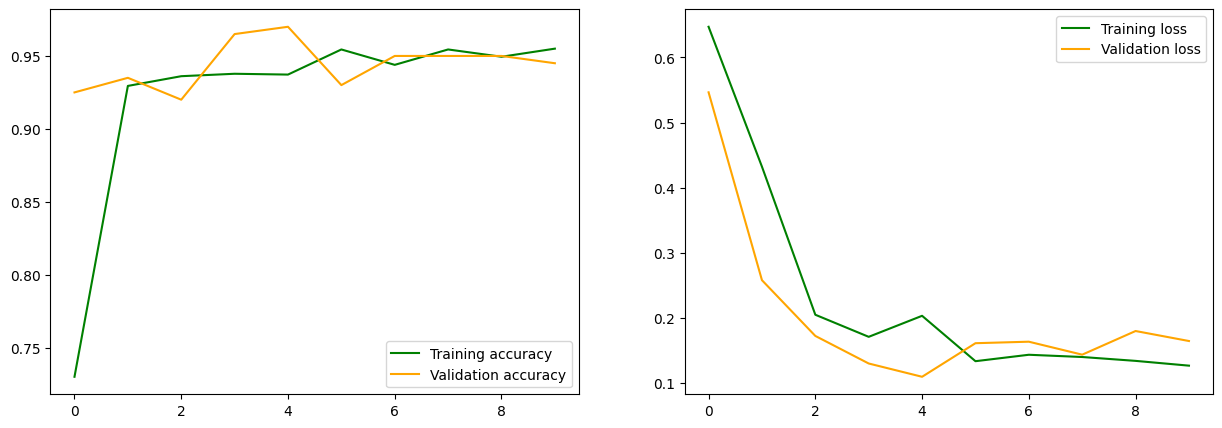

In [16]:
train_loop(10, 300, 0.005)

Epoch : 1, training accuracy : 0.8493750095367432, training loss : 0.40223097801208496
Epoch : 1, validation accuracy : 0.949999988079071, validation loss : 0.16875609755516052
Epoch : 2, training accuracy : 0.9168749451637268, training loss : 0.2221461981534958
Epoch : 2, validation accuracy : 0.9049999713897705, validation loss : 0.2859657406806946
Epoch : 3, training accuracy : 0.9399999380111694, training loss : 0.17629683017730713
Epoch : 3, validation accuracy : 0.9299999475479126, validation loss : 0.25661078095436096
Epoch : 4, training accuracy : 0.9324999451637268, training loss : 0.18577304482460022
Epoch : 4, validation accuracy : 0.9249999523162842, validation loss : 0.1832086443901062
Epoch : 5, training accuracy : 0.9449999332427979, training loss : 0.15054117143154144
Epoch : 5, validation accuracy : 0.9399999976158142, validation loss : 0.18435484170913696
Epoch : 6, training accuracy : 0.949999988079071, training loss : 0.13782338798046112
Epoch : 6, validation accura

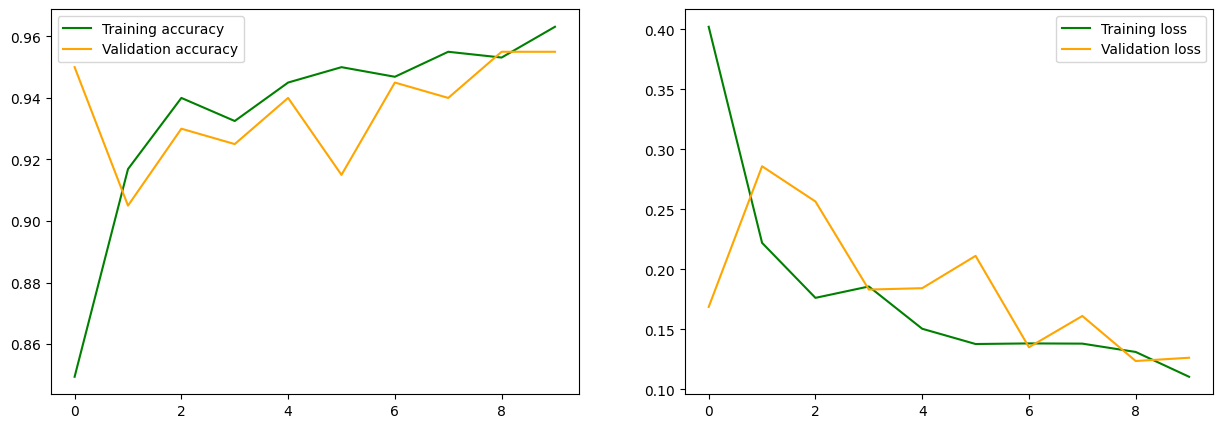

In [17]:
train_loop(10, 100, 0.007)

Epoch : 1, training accuracy : 0.7587500214576721, training loss : 0.6007959246635437
Epoch : 1, validation accuracy : 0.8899999856948853, validation loss : 0.39833754301071167
Epoch : 2, training accuracy : 0.9237499237060547, training loss : 0.2634299099445343
Epoch : 2, validation accuracy : 0.9149999618530273, validation loss : 0.25537535548210144
Epoch : 3, training accuracy : 0.9325000047683716, training loss : 0.20536862313747406
Epoch : 3, validation accuracy : 0.9199999570846558, validation loss : 0.23233909904956818
Epoch : 4, training accuracy : 0.9375, training loss : 0.17245714366436005
Epoch : 4, validation accuracy : 0.9449999928474426, validation loss : 0.177259624004364
Epoch : 5, training accuracy : 0.93812495470047, training loss : 0.16611216962337494
Epoch : 5, validation accuracy : 0.9449999928474426, validation loss : 0.18093709647655487
Epoch : 6, training accuracy : 0.9356250166893005, training loss : 0.1826377511024475
Epoch : 6, validation accuracy : 0.9449999

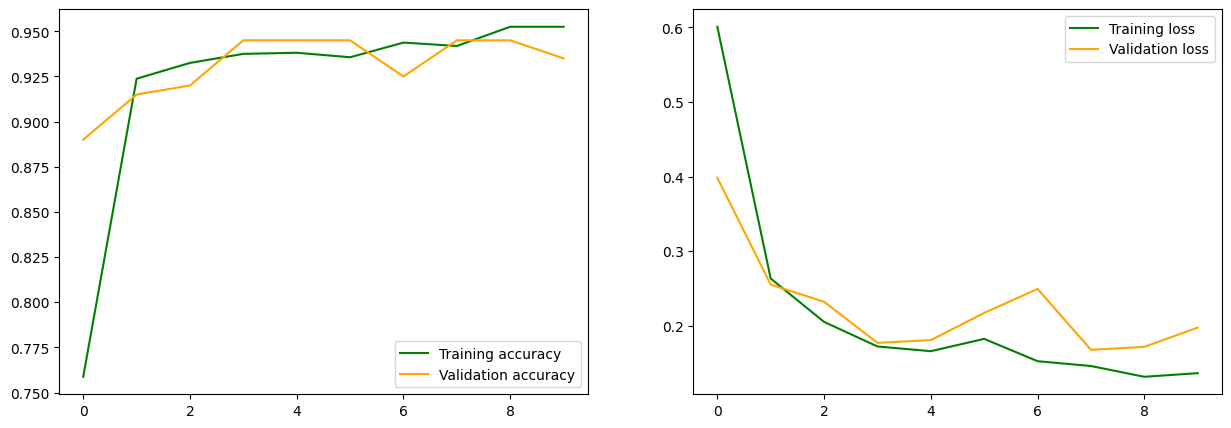

In [18]:
train_loop(10, 200, 0.007)

Epoch : 1, training accuracy : 0.5049999952316284, training loss : 0.6491416096687317
Epoch : 1, validation accuracy : 0.6349999904632568, validation loss : 0.5552744269371033
Epoch : 2, training accuracy : 0.823888897895813, training loss : 0.47789353132247925
Epoch : 2, validation accuracy : 0.9300000071525574, validation loss : 0.38593417406082153
Epoch : 3, training accuracy : 0.9305555820465088, training loss : 0.3374220132827759
Epoch : 3, validation accuracy : 0.9399999976158142, validation loss : 0.25983723998069763
Epoch : 4, training accuracy : 0.9283334016799927, training loss : 0.2364155799150467
Epoch : 4, validation accuracy : 0.9199999570846558, validation loss : 0.2120809555053711
Epoch : 5, training accuracy : 0.9316666126251221, training loss : 0.18991202116012573
Epoch : 5, validation accuracy : 0.9300000071525574, validation loss : 0.2310137152671814
Epoch : 6, training accuracy : 0.9338889122009277, training loss : 0.1617470383644104
Epoch : 6, validation accuracy 

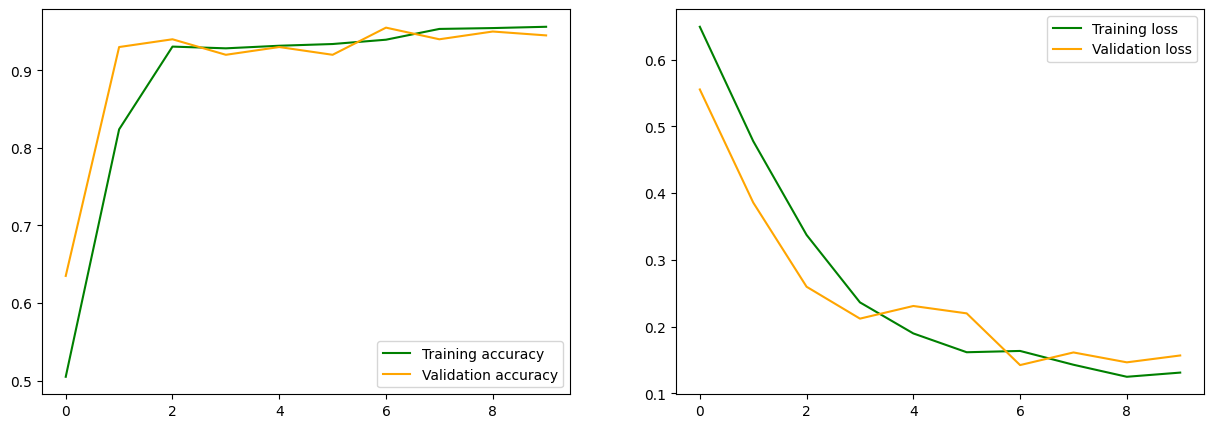

In [19]:
train_loop(10, 300, 0.007)

Из предоставленных данных видно, что при batch size 100 и learning rate 0.001 модель достигает высокой точности как на обучающем, так и на проверочном наборе данных. Однако, увеличение batch size до 200 и 300 приводит к начальной потере точности. Тем не менее, с увеличением количества эпох (epochs) точность увеличивается для всех размеров пакетов.

Скорость обучения (learning rate) также имеет влияние на точность модели. Например, при более высокой скорости обучения (0.005 и 0.007) модели достигают высокой точности, но иногда они более чувствительны к колебаниям в точности на проверочных данных.

Модель с параметрами batch size 100 и learning rate 0.001 имеет стабильную и высокую точность на обучающих и проверочных данных.
Увеличение batch size ухудшает начальную точность модели, но с увеличением количества эпох точность улучшается.
Более высокие скорости обучения (0.005 и 0.007) также позволяют модели достичь высокой точности, но могут быть менее стабильными.

Запись результатов

In [20]:
polar_bear_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=100, shuffle=False
)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = functional.softmax(preds, dim=1)[:, 1].tolist()
        polar_bear_probs += list(zip(list(fileid), preds_list))
polar_bear_probs.sort(key=lambda x: int(x[0]))
polar_bear_probs[17:24]

[(tensor(0), 0.188869908452034),
 (tensor(0), 0.6110966205596924),
 (tensor(0), 0.012353012338280678),
 (tensor(0), 0.2796866297721863),
 (tensor(0), 0.027306657284498215),
 (tensor(0), 0.3257691562175751),
 (tensor(0), 0.05421797186136246)]

In [21]:
idx = list(i for i in range(len(polar_bear_probs)))
prob = list(map(lambda x: x[1],polar_bear_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,0,0.846452
1,1,0.096155
2,2,0.021972
3,3,0.031364
4,4,0.021180
...,...,...
195,195,0.996214
196,196,0.997862
197,197,0.999991
198,198,0.968828


Сохранение результатов

In [22]:
name_model = "model.pth"
torch.save(model.state_dict(), os.path.join("C:/Users/zhura/Desktop", name_model))

Проверка работоспособности нашей обученной модели

In [23]:
re_model = Cnn()
re_model.load_state_dict(torch.load(os.path.join("C:/Users/zhura/Desktop", name_model)))

<All keys matched successfully>

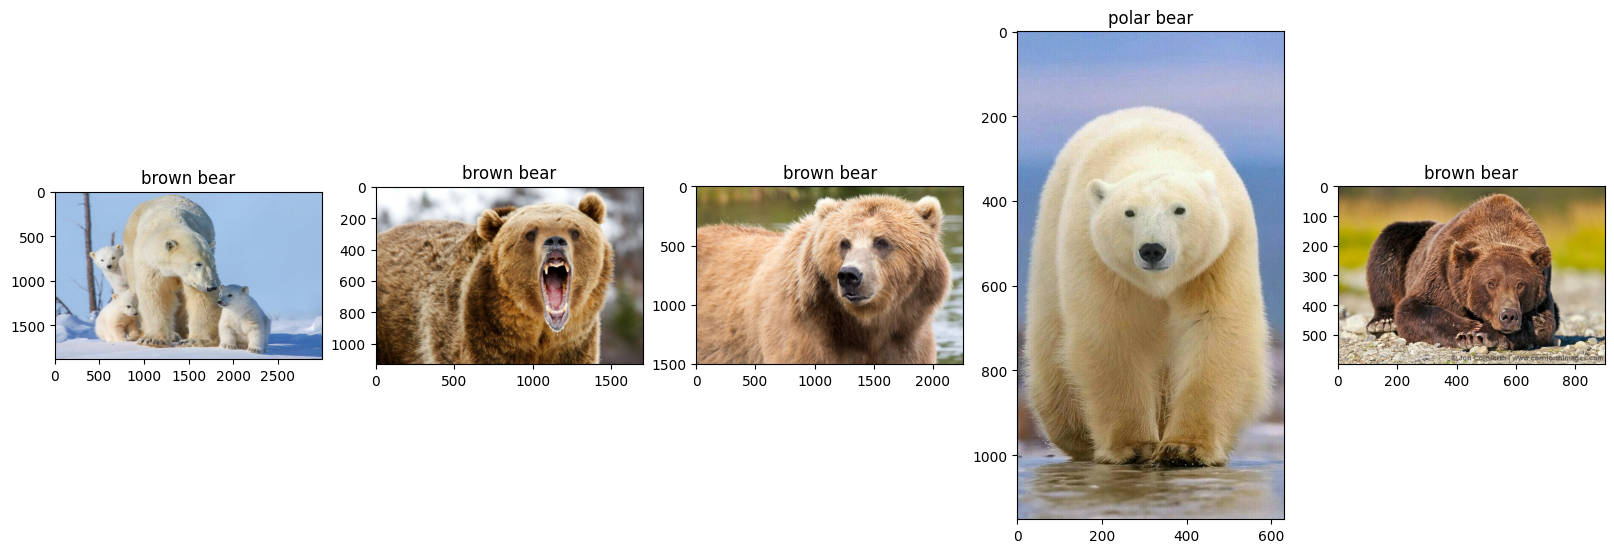

In [24]:
id_list = []

class_ = {0: 'polar bear', 1: 'brown bear'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

Как видно, модель весьма точно определила класс картинки